In [1]:
import cv2 as cv
import numpy as np
from imutils import contours
import kociemba
# from datetime import datetime

In [2]:
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, deltaE_cie76#,deltaE_ciede2000,deltaE_ciede94

In [3]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [5]:
def identify_color(image,color_list,threshold=60):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_color = get_colors(image, 1, False)
#     print(image_color)
    image_color = rgb2lab(np.uint8(np.asarray([[image_color]])))
    possible_match = {}
    for val in color_list:
#         print(f"val is {val}")
        curr_color = rgb2lab(np.uint8(np.asarray([color_list[val]])))
        diff = deltaE_cie76(image_color, curr_color)
#         diff = deltaE_ciede94(image_color, curr_color)
        
#         diff = deltaE_ciede2000(image_color, curr_color)
        
#         print(diff[0][0][0])
        if (diff < threshold):
            possible_match[int(diff[0][0][0])] = val
    
    possible_match = dict(sorted(possible_match.items()))
    print(possible_match)
    return list(possible_match.values())[0]

In [6]:
def get_image(image_path):
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    return image

In [7]:
def get_colors(image, number_of_colors, show_chart):
    
#     modified_image = image.copy()
    modified_image = cv.resize(image, (600, 400), interpolation = cv.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
#     print("inside rgb_colors is ",rgb_colors)
    return rgb_colors

[array([ 26.75747888,  59.11207822, 111.9013861 ]),
 array([203.3298165 ,  95.42280219,  14.25139453]),
 array([180.25348464, 184.73235153, 188.40587954]),
 array([154.06384647,  25.13592804,  19.39408348]),
 array([192.42392271, 173.92311759,   2.62741234]),
 array([ 7.74207151, 89.74207151, 66.08612766])]

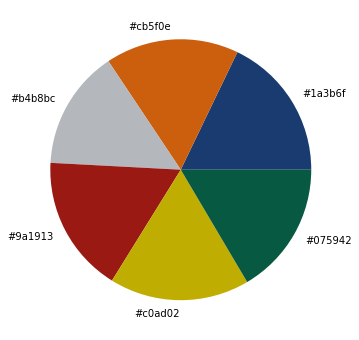

In [8]:
get_colors(get_image('images/colors.jpg'), 6, True)

In [9]:
# [array([184.041793  ,  86.70871917,  27.80222077]), orange
#  array([19.65844721, 99.40294004, 50.53381903]),
#  array([180.95730246, 156.87009815,  11.83821068]),
#  array([23.40360149, 40.62052261, 92.8763946 ]),
#  array([140.70223789,  31.6402395 ,  27.26374793])] red


COLORS = {
    'F': [7,89,67], #green
    'U': [180,185,189], #white
    'D': [180,156,11],#yellow
    'B' : [26,59,120],#blue
    'L':[201,92,19],#orange
    'R':[190,31,42] #red
#     'Green': [7,89,67],
#     'White': [180,185,189],
#     'Yellow': [180,156,11],
#     'Blue' : [26,59,120],
#     'Orange':[201,92,19],
#     'Red':[190,31,33]
}

# COLORS = {
#     'Green': [7,89,67],
#     'White': [180,185,189],
#     'Yellow': [193,177,2],
#     'Blue' : [26,59,112],
#     'Orange':[180,95,13],
#     'Red':[140,30,37]
# }

In [10]:
# working
def find_colors(img,color_list):
#     img = cv.imread("./images/D1.jpeg")
    original  = img.copy()
#     cv.imshow('img',img) 
    height, width, _ = original.shape
    print(f"height = {height}, width = {width}")
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

    # type of blur which preserves edges
    # blur = cv.bilateralFilter(gray, 7, 7,10)
    # sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    # sharpen_kernel_5 = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    # sharpen_kernel_4 = np.array([[0,1,0], [1,-4,1], [0,1,0]])

    # sharpen = cv.filter2D(blur, -1, sharpen_kernel)
    # sharpen_4 = cv.filter2D(blur, -1, sharpen_kernel_4)
    # sharpen_5 = cv.filter2D(blur, -1, sharpen_kernel_5)
    # sharpen = cv.filter2D(blur, -1, sharpen_kernel)
    # sharpen = cv.filter2D(blur, -1, sharpen_kernel)


    # thresh = cv.adaptiveThreshold(sharpen,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV,9,1)
    thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
    kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))



    thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
    thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
    # thresh = cv.threshold(thresh,127,255,cv.THRESH_BINARY)

    cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
    # cnts = cv.findContours(close,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)

    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    # (cnts, _) = contours.sort_contours(cnts, method="left-to-right")
    cnts = sorted(cnts, key=lambda x: cv.contourArea(x))


    number = 0
    min_area = 34000
    max_area = 50000
    x = y = w = h = 0
    for c in cnts:
        area = cv.contourArea(c)
        if area > min_area and area < max_area:
            print(area)
            x,y,w,h = cv.boundingRect(c)
    #         print(x,y,w,h,end=" ")
            tmp = original[y:y+h, x:x+w]
    #         cv.imshow("{}".format(number + 1),tmp)
    #         sq_color = identify_color(tmp)
#             cv.drawContours(image=original, contours=c, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv.LINE_AA)
            cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
    #         original[y:y+h,x:x+w] = [255,255,255]
    #         original = cv.circle(original,((x+x+w)//2 , (y+y+h)//2),radius=1, color=(255, 255, 255), thickness=-1)
            number += 1
#             cv.imwrite(f"new_{random.randint(0,100)}.jpeg",tmp)
    #         cv.putText(original, "#{}".formatnumber), (x,y - 5), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            break

    # cv.imshow('tmp',tmp)
    # print("dims = ",x,y,w,h,end=" ")
    colors = []
    for i in range(1,4):
        for j in range(1,4):
            sq = original[y + (i-1)* (h//3):y+(i)* (h//3),x+(j-1)*(w//3):x+(j)*(w//3)]
    #         cv.rectangle(original,(x+(j-1)*(w//3),y + (i-1)* (h//3)),(x+(j)*(w//3),y+(i)* (h//3)),(36,255,12), 2)
#             original = cv.circle(original, ((x+(j-1)*(w//3) + x+(j)*(w//3))//2 ,(y + (i-1)* (h//3) + y+(i)* (h//3))//2), radius=10, color=(0, 0, 255), thickness=-1)
            color = identify_color(sq,color_list)
            colors.append(color)
            cv.putText(original, "#{}".format(color), (x+(j-1)*(w//3),y + (i-1)* (h//3) - 5), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            
    #         cv.imshow(f'square ({i},{j})',sq)\
    colors = ''.join(colors)
    # colors = str(colors)
#     print(colors)
#     cv.imshow('thresh',thresh)
#     resized_thresh = cv.resize(thresh, (300,600), interpolation= cv.INTER_LINEAR)
#     cv.imshow('resized_thresh',resized_thresh)
    # cv.imshow('sharpen_4',sharpen_4)
    # cv.imshow('sharpen_5',sharpen_5)
    # cv.imshow('blur', blur)
    # cv.imshow('gray',gray)
    # cv.imshow('original', original)
    resized_down = cv.resize(original, (400,400), interpolation= cv.INTER_LINEAR)
    cv.imshow('resized',resized_down)

    # cv.imshow('sharpen',sharpen)
#     cv.waitKey()
#     cv.destroyWindow('resized')
    return colors

In [11]:
import sys
front_face=right_face=back_face=left_face=up_face=down_face = ""

In [12]:
def detect_face_of_cube(video,COLORS,face_no,text=""):
#     while True:
    isTrue,img = video.read()
    cv.imshow(text,img)
    if not isTrue:
        print("Cannot read video source")
        return
    global front_face
    global right_face
    global left_face
    global back_face
    global up_face
    global down_face

    if face_no == 1:
        front_face = find_colors(img,COLORS)
    elif face_no == 2:
        right_face = find_colors(img,COLORS)
    elif face_no == 3:
        back_face = find_colors(img,COLORS)
    elif face_no == 4:
        left_face = find_colors(img,COLORS)
    elif face_no == 5:
        up_face = find_colors(img,COLORS)
    elif face_no == 6:
        down_face = find_colors(img,COLORS)
#     key_pressed = cv.waitKey(1) & 0xFF
#     if key_pressed == 27 or key_pressed == ord('d'):
#         break

#     video.release()
#     cv.destroyAllWindows()



In [13]:
# working
video = cv.VideoCapture(2)
isTrue, img = video.read()
broke = 0
h1 = img.shape[0]
w1 = img.shape[1]

print(f"h = {h1},w = {w1}")
instructions = {
    1 : "Show Front Face",
    2 : "Show Right Face",
    3 : "Show Back Face",
    4 : "Show Left Face",
    5 : "Show Up Face",
    6 : "Show Down Face"
}

if not isTrue:
    print("Cannot read video source")
    sys.exit()
index = 1
while True:
    isTrue,img = video.read()
    if not isTrue:
        break
    x = w1//2 - 4*h1//16
    y = h1//3
    w = 4*h1//10
    h = 4*h1//10
#     cv.rectangle(img, (x, y), (x + w, y + h), (36,255,12), 2)

    if index<7:
        cv.imshow(instructions[index],img)
    if cv.waitKey(1) == ord('c') and index<7: # extracting color from cube after click 'c' on keyboard
        print("start processing")
        try:
            detect_face_of_cube(video,COLORS,index,instructions[index])
            if index<6:
                cv.destroyWindow(instructions[index])
            index = index + 1
        except:
            cv.imshow("Please place cube correctly",img)
        
    if cv.waitKey(1) == ord('s'): # start kociema module     
        kociema(color)
    if cv.waitKey(1) == ord('q'):
        break
video.release()
cv.destroyAllWindows()

h = 480,w = 640
start processing
height = 480, width = 640
41550.0
{32: 'L', 40: 'D', 46: 'R', 55: 'F', 57: 'U'}
{24: 'D', 49: 'L'}
{22: 'B', 41: 'F', 57: 'U'}
{37: 'R', 44: 'L'}
{11: 'F', 58: 'U'}
{32: 'L', 38: 'R', 50: 'D', 59: 'F'}
{39: 'R', 45: 'L', 58: 'F'}
{23: 'D', 48: 'L', 50: 'F', 59: 'U'}
{21: 'U', 35: 'F', 57: 'D', 59: 'B'}
start processing
height = 480, width = 640
41609.0
{22: 'U', 33: 'F', 54: 'D'}
{11: 'F', 58: 'U'}
{24: 'D', 49: 'F', 51: 'L'}
{21: 'U', 34: 'F', 56: 'D'}
{35: 'R', 44: 'L'}
{20: 'B', 47: 'F'}
{31: 'L', 43: 'R', 56: 'F', 59: 'U'}
{35: 'R', 44: 'L'}
{20: 'B', 43: 'F', 59: 'U'}
start processing
height = 480, width = 640
41664.5
{23: 'B', 39: 'F', 57: 'U'}
{30: 'L', 41: 'R', 45: 'D', 58: 'F'}
{31: 'L', 40: 'R', 46: 'D', 58: 'F'}
{21: 'D', 50: 'L', 52: 'F'}
{14: 'B', 53: 'F'}
{17: 'B', 52: 'F'}
{30: 'L', 41: 'R', 43: 'D', 58: 'F', 59: 'U'}
{7: 'F', 55: 'U'}
{8: 'F', 55: 'U'}
start processing
height = 480, width = 640
41715.0
{13: 'F', 58: 'U'}
{27: 'D', 47: 'F

In [14]:
def concat_final(front_face,right_face,back_face,left_face,up_face,down_face):
    final_str = ""
    final_str = final_str + up_face
    final_str = final_str + right_face
    final_str = final_str + front_face  
    final_str = final_str + down_face 
    final_str = final_str + left_face
    final_str = final_str + back_face 
    print(final_str)
    return final_str

In [15]:
print(f"front face is {front_face}")
print(f"right face is {right_face}")
print(f"back face is {back_face}")
print(f"left face is {left_face}")
print(f"up face is {up_face}")
print(f"down face is {down_face}")
final_str = concat_final(front_face,right_face,back_face,left_face,up_face,down_face)
# print(back_str)
print(final_str)
# # # down = 
# # # UUUUUUUUURRRRRRRRRFFFFFFFFFDDDDDDDDDLLLLLLLLLBBBBBBBBB
steps_to_follow = kociemba.solve(final_str)
steps_to_follow

front face is LDBRFLRDU
right face is UFDURBLRB
back face is BLLDBBLFF
left face is FDFULUUBF
up face is UFRLUUDRR
down face is DFBLDBRRD
UFRLUUDRRUFDURBLRBLDBRFLRDUDFBLDBRRDFDFULUUBFBLLDBBLFF
UFRLUUDRRUFDURBLRBLDBRFLRDUDFBLDBRRDFDFULUUBFBLLDBBLFF


"F U B2 L B D L D R' B2 L' F2 L2 U' F2 U' L2 U B2"

In [16]:
from datetime import datetime,timedelta

In [17]:
def time_to_seconds(time):
    time_lst = time.split(":")
    seconds = 0
    seconds = int(time_lst[0])*60*60 + int(time_lst[1])*60 + int(time_lst[2])
    return seconds

def time_taken(start_time,end_time):
    sec = time_to_seconds(end_time) - time_to_seconds(start_time)
    return sec

In [18]:
def return_points(x,y,w,h):
    point_lst = []
    for i in range(1,4):
        for j in range(1,4):
            point_lst.append((x + (2*j-1)*w//6,y + (2*i-1)*h//6))
    print(point_lst)
    return point_lst

In [19]:
# def r_clk(video):
#     now = datetime.now()
#     start_time = now.strftime("%H:%M:%S")
#     while True:
#         if(time_taken(start_time,datetime.now().strftime("%H:%M:%S")) < 5):
#             isTrue, img = video.read()
#             if not isTrue:
#                 print("Cannot read video source")
#                 sys.exit()
#             cv.imshow("Output",img)
#             original  = img.copy()
#             height, width, _ = original.shape
#             gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
#             thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
#             kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
#             thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
#             thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
#             cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
#             cnts = cnts[0] if len(cnts) == 2 else cnts[1]
#             cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
#             number = 0
#             min_area = 34000
#             max_area = 50000
#             x = y = w = h = 0
#             for c in cnts:
#                 area = cv.contourArea(c)
#                 if area > min_area and area < max_area:
#                     print(area)
#                     x,y,w,h = cv.boundingRect(c)
#     #                 tmp = original[y:y+h, x:x+w]
#     #                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
#                     number += 1
#                     break
#             points_lst = return_points(x,y,w,h)
#             cv.arrowedLine(img, points_lst[8], points_lst[2], (0, 0, 0), 7, tipLength = 0.2)
#             cv.arrowedLine(img, points_lst[8], points_lst[2], (255,255,255), 4, tipLength = 0.2)
#             cv.imshow("Output",img)
#         else:
#             video.release()
#             break

In [20]:
def r_clk(video):
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[8], points_lst[2], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[8], points_lst[2], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [21]:
def r_anticlk(video):
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[2], points_lst[8], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[2], points_lst[8], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [22]:
def l_clk(video):
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[0], points_lst[6], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[0], points_lst[6], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [23]:
def l_anticlk(video):
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[6], points_lst[0], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[6], points_lst[0], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [24]:
def f_clk(video):
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        
        cv.arrowedLine(img, points_lst[3], points_lst[1], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[3], points_lst[1], (255,255,255), 4, tipLength = 0.2)
        
        cv.arrowedLine(img, points_lst[1], points_lst[5], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[1], points_lst[5], (255,255,255), 4, tipLength = 0.2)
        
        cv.arrowedLine(img, points_lst[5], points_lst[7], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[5], points_lst[7], (255,255,255), 4, tipLength = 0.2)
        
        cv.arrowedLine(img, points_lst[7], points_lst[3], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[7], points_lst[3], (255,255,255), 4, tipLength = 0.2)
        
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break
            

In [25]:
def f_anticlk(video):
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        
        cv.arrowedLine(img,points_lst[1], points_lst[3],  (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img,  points_lst[1],points_lst[3], (255,255,255), 4, tipLength = 0.2)
        
        cv.arrowedLine(img, points_lst[5], points_lst[1], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[5], points_lst[1], (255,255,255), 4, tipLength = 0.2)
        
        cv.arrowedLine(img, points_lst[7], points_lst[5], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[7], points_lst[5], (255,255,255), 4, tipLength = 0.2)
        
        cv.arrowedLine(img, points_lst[3], points_lst[7], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[3], points_lst[7], (255,255,255), 4, tipLength = 0.2)
        
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break
            

In [26]:
def u_clk(video):
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[2], points_lst[0], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[2], points_lst[0], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [27]:
def u_anticlk(video):
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[0], points_lst[2], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[0], points_lst[2], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [28]:
def d_clk(video):
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[6], points_lst[8], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[6], points_lst[8], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [29]:
def d_anticlk(video):
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[8], points_lst[6], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[8], points_lst[6], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [30]:
def turn_left(video):
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        
        cv.arrowedLine(img, points_lst[0], points_lst[2], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[0], points_lst[2], (255,255,255), 4, tipLength = 0.2)
                
        cv.arrowedLine(img, points_lst[3], points_lst[5], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[3], points_lst[5], (255,255,255), 4, tipLength = 0.2)
                
        cv.arrowedLine(img, points_lst[6], points_lst[8], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[6], points_lst[8], (255,255,255), 4, tipLength = 0.2)
        
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [31]:
def turn_right(video):
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        
        cv.arrowedLine(img,points_lst[2], points_lst[0],  (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img,points_lst[2], points_lst[0],  (255,255,255), 4, tipLength = 0.2)
                
        cv.arrowedLine(img,points_lst[5], points_lst[3],  (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img,points_lst[5], points_lst[3],  (255,255,255), 4, tipLength = 0.2)
                
        cv.arrowedLine(img,points_lst[8], points_lst[6],  (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img,points_lst[8], points_lst[6],  (255,255,255), 4, tipLength = 0.2)
        
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [32]:
# # steps = steps_to_follow.split()
# video = cv.VideoCapture(2)
# isTrue, img = video.read()
# if not isTrue:
#     sys.exit()
# r_clk(video)
# r_anticlk(video)
# l_clk(video)
# l_anticlk(video)
# f_anticlk(video)
# f_clk(video)
# u_clk(video)
# u_anticlk(video)
# d_clk(video)
# d_anticlk(video)
# turn_right(video)
# turn_left(video)
# video.release()
# cv.destroyAllWindows()



In [33]:

# now = datetime.now()
# start_time = now.strftime("%H:%M:%S")
# while True:
#     if(time_taken(start_time,datetime.now().strftime("%H:%M:%S")) < 5):
#         isTrue, img = video.read()
#         if not isTrue:
#             print("Cannot read video source")
#             sys.exit()
#         r_clk(video)
#     else:
#         video.release()
#         break
video = cv.VideoCapture(2)
isTrue, img = video.read()

# r_clk(video)
# r_anticlk(video)
# l_clk(video)
# l_anticlk(video)
# f_anticlk(video)
# f_clk(video)
# u_clk(video)
# u_anticlk(video)
# d_clk(video)
# d_anticlk(video)
# turn_right(video)
# turn_left(video)
step_lst = steps_to_follow.split(" ")

for step in step_lst:
    if step == "R":
        r_clk(video)
    elif step == "R'":
        r_anticlk(video)
    elif step == "R2":
        r_clk(video)
        r_clk(video)
    elif step == "L":
        l_clk(video)
    elif step == "L'":
        l_anticlk(video)
    elif step == "L2":
        l_clk(video)
        l_clk(video)
    elif step == "F":
        f_clk(video)
    elif step == "F'":
        f_anticlk(video)
    elif step == "F2":
        f_clk(video)
        f_clk(video)
    elif step == "B":
        turn_right(video)
        r_clk(video)
        turn_left(video)
    elif step == "B'":
        turn_right(video)
        r_anticlk(video)
        turn_left(video)
    elif step == "B2":
        turn_right(video)
        r_clk(video)
        r_clk(video)
        turn_left(video)
    elif step == "U":
        u_clk(video)
    elif step == "U'":
        u_anticlk(video)
    elif step == "U2":
        u_clk(video)
        u_clk(video)
    elif step == "D":
        d_clk(video)
    elif step == "D'":
        d_anticlk(video)
    elif step == "D2":
        d_clk(video)
        d_clk(video)
    else:
        pass


[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
34297.0
[(216, 120), (386, 120), (555, 120), (216, 264), (386, 264), (555, 264), (216, 408), (386, 408), (555, 408)]
34297.0
[(216, 120), (386, 120), (555, 120), (216, 264), (386, 264), (555, 264), (216, 408), (386, 408), (555, 408)]
34780.0
[(230, 80), (394, 80), (558, 80), (230, 240), (394, 240), (558, 240), (230, 400), (394, 400), (558, 400)]
44619.5
[(106, 80), (320, 80), (533, 80), (106, 240), (320, 240), (533, 240), (106, 400), (320, 400), (533, 400)]
44619.5
[(106, 80), (320, 80), (533, 80), (106, 240), (320, 240), (533, 240), (106, 400), (320, 400), (533, 400)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
43308.0
[(102, 80), (308, 80), (513, 80), (102, 240), (308,

41390.5
[(286, 217), (358, 217), (429, 217), (286, 289), (358, 289), (429, 289), (286, 360), (358, 360), (429, 360)]
41399.5
[(286, 217), (358, 217), (429, 217), (286, 289), (358, 289), (429, 289), (286, 360), (358, 360), (429, 360)]
41399.5
[(286, 217), (358, 217), (429, 217), (286, 289), (358, 289), (429, 289), (286, 360), (358, 360), (429, 360)]
41389.5
[(286, 217), (358, 217), (429, 217), (286, 289), (358, 289), (429, 289), (286, 360), (358, 360), (429, 360)]
41396.5
[(286, 217), (358, 217), (429, 217), (286, 289), (358, 289), (429, 289), (286, 360), (358, 360), (429, 360)]
41396.5
[(286, 217), (358, 217), (429, 217), (286, 289), (358, 289), (429, 289), (286, 360), (358, 360), (429, 360)]
41395.5
[(286, 217), (358, 217), (429, 217), (286, 289), (358, 289), (429, 289), (286, 360), (358, 360), (429, 360)]
41392.5
[(286, 217), (358, 217), (429, 217), (286, 289), (358, 289), (429, 289), (286, 360), (358, 360), (429, 360)]
41389.5
[(286, 217), (358, 217), (429, 217), (286, 289), (358, 2

35875.5
[(94, 179), (284, 179), (473, 179), (94, 299), (284, 299), (473, 299), (94, 419), (284, 419), (473, 419)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
34370.5
[(106, 186), (320, 186), (533, 186), (106, 304), (320, 304), (533, 304), (106, 421), (320, 421), (533, 421)]
45968.0
[(106, 173), (320, 173), (533, 173), (106, 296), (320, 296), (533, 296), (106, 418), (320, 418), (533, 418)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
35923.5
[(55, 194), (165, 194), (275, 194), (55, 308), (165, 308), (275, 308), (55, 422), (165, 422), (275, 422)]
[(0, 0), (0, 0), (0, 0), (0

41495.0
[(302, 241), (372, 241), (441, 241), (302, 310), (372, 310), (441, 310), (302, 379), (372, 379), (441, 379)]
41495.0
[(302, 241), (372, 241), (441, 241), (302, 310), (372, 310), (441, 310), (302, 379), (372, 379), (441, 379)]
41491.5
[(302, 241), (372, 241), (441, 241), (302, 310), (372, 310), (441, 310), (302, 379), (372, 379), (441, 379)]
41497.5
[(302, 241), (372, 241), (441, 241), (302, 310), (372, 310), (441, 310), (302, 379), (372, 379), (441, 379)]
41491.0
[(302, 241), (372, 241), (441, 241), (302, 310), (372, 310), (441, 310), (302, 379), (372, 379), (441, 379)]
41491.0
[(302, 241), (372, 241), (441, 241), (302, 310), (372, 310), (441, 310), (302, 379), (372, 379), (441, 379)]
41500.0
[(302, 241), (372, 241), (441, 241), (302, 310), (372, 310), (441, 310), (302, 379), (372, 379), (441, 379)]
41491.5
[(302, 241), (372, 241), (441, 241), (302, 310), (372, 310), (441, 310), (302, 379), (372, 379), (441, 379)]
41491.5
[(302, 241), (372, 241), (441, 241), (302, 310), (372, 3

41495.5
[(302, 241), (372, 241), (441, 241), (302, 310), (372, 310), (441, 310), (302, 379), (372, 379), (441, 379)]
41495.5
[(302, 241), (372, 241), (441, 241), (302, 310), (372, 310), (441, 310), (302, 379), (372, 379), (441, 379)]
41506.0
[(302, 241), (372, 241), (441, 241), (302, 310), (372, 310), (441, 310), (302, 379), (372, 379), (441, 379)]
41497.5
[(302, 241), (372, 241), (441, 241), (302, 310), (372, 310), (441, 310), (302, 379), (372, 379), (441, 379)]
41497.5
[(302, 241), (372, 241), (441, 241), (302, 310), (372, 310), (441, 310), (302, 379), (372, 379), (441, 379)]
41497.5
[(302, 241), (372, 241), (441, 241), (302, 310), (372, 310), (441, 310), (302, 379), (372, 379), (441, 379)]
41495.5
[(302, 241), (372, 241), (441, 241), (302, 310), (372, 310), (441, 310), (302, 379), (372, 379), (441, 379)]
41492.0
[(302, 241), (372, 241), (441, 241), (302, 310), (372, 310), (441, 310), (302, 379), (372, 379), (441, 379)]
41492.0
[(302, 241), (372, 241), (441, 241), (302, 310), (372, 3

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
40189.0
[(106, 80), (320, 80), (533, 80), (106, 240), (320, 240), (533, 240), (106, 400), (320, 400), (533, 400)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
34858.0
[(106, 146), (320, 146), (533, 146), (106, 280), (320, 280), (533, 280), (106, 413), (320, 413), (533, 413)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
34695.5
[(106, 155), (320, 155), (533, 155), (106, 285), (320, 285), (533, 285), (106, 415), (320, 415), (533, 4

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0

36254.5
[(226, 162), (392, 162), (557, 162), (226, 289), (392, 289), (557, 289), (226, 416), (392, 416), (557, 416)]
36254.5
[(226, 162), (392, 162), (557, 162), (226, 289), (392, 289), (557, 289), (226, 416), (392, 416), (557, 416)]
34759.0
[(154, 118), (348, 118), (542, 118), (154, 263), (348, 263), (542, 263), (154, 407), (348, 407), (542, 407)]
36766.0
[(145, 160), (343, 160), (541, 160), (145, 288), (343, 288), (541, 288), (145, 416), (343, 416), (541, 416)]
36766.0
[(145, 160), (343, 160), (541, 160), (145, 288), (343, 288), (541, 288), (145, 416), (343, 416), (541, 416)]
36277.5
[(220, 80), (388, 80), (556, 80), (220, 240), (388, 240), (556, 240), (220, 400), (388, 400), (556, 400)]
39249.5
[(199, 156), (375, 156), (551, 156), (199, 286), (375, 286), (551, 286), (199, 415), (375, 415), (551, 415)]
34551.5
[(167, 162), (356, 162), (545, 162), (167, 289), (356, 289), (545, 289), (167, 416), (356, 416), (545, 416)]
34551.5
[(167, 162), (356, 162), (545, 162), (167, 289), (356, 289)

42588.0
[(275, 190), (345, 190), (414, 190), (275, 274), (345, 274), (414, 274), (275, 358), (345, 358), (414, 358)]
42588.0
[(275, 190), (345, 190), (414, 190), (275, 274), (345, 274), (414, 274), (275, 358), (345, 358), (414, 358)]
37531.5
[(186, 166), (368, 166), (549, 166), (186, 292), (368, 292), (549, 292), (186, 417), (368, 417), (549, 417)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
36289.0
[(140, 183), (340, 183), (540, 183), (140, 293), (340, 293), (540, 293), (140, 403), (340, 403), (540, 403)]
36289.0
[(140, 183), (340, 183), (540, 183), (140, 293), (340, 293), (540, 293), (140, 403), (340, 403), (540, 403)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (

41444.0
[(250, 226), (320, 226), (390, 226), (250, 296), (320, 296), (390, 296), (250, 365), (320, 365), (390, 365)]
41444.0
[(250, 226), (320, 226), (390, 226), (250, 296), (320, 296), (390, 296), (250, 365), (320, 365), (390, 365)]
41436.0
[(250, 226), (320, 226), (390, 226), (250, 296), (320, 296), (390, 296), (250, 365), (320, 365), (390, 365)]
41447.0
[(250, 226), (320, 226), (390, 226), (250, 296), (320, 296), (390, 296), (250, 365), (320, 365), (390, 365)]
41444.0
[(250, 226), (320, 226), (390, 226), (250, 296), (320, 296), (390, 296), (250, 365), (320, 365), (390, 365)]
41444.0
[(250, 226), (320, 226), (390, 226), (250, 296), (320, 296), (390, 296), (250, 365), (320, 365), (390, 365)]
41442.0
[(250, 226), (320, 226), (390, 226), (250, 296), (320, 296), (390, 296), (250, 365), (320, 365), (390, 365)]
41442.0
[(250, 226), (320, 226), (390, 226), (250, 296), (320, 296), (390, 296), (250, 365), (320, 365), (390, 365)]
41442.0
[(250, 226), (320, 226), (390, 226), (250, 296), (320, 2

39899.0
[(114, 200), (324, 200), (534, 200), (114, 288), (324, 288), (534, 288), (114, 376), (324, 376), (534, 376)]
40152.0
[(131, 147), (335, 147), (538, 147), (131, 256), (335, 256), (538, 256), (131, 365), (335, 365), (538, 365)]
40152.0
[(131, 147), (335, 147), (538, 147), (131, 256), (335, 256), (538, 256), (131, 365), (335, 365), (538, 365)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
43927.0
[(106, 70), (320, 70), (533, 70), (106, 212), (320, 212), (533, 212), (106, 353), (320, 353), (533, 353)]
43927.0
[(106, 70), (320, 70), (533, 70), (106, 212), (320, 212), (533, 212), (106, 353), (320, 353), (533, 353)]
40704.0
[(149, 67), (345, 67), (541, 67), (149, 201), (345, 201), (541, 201), (149, 335), (345, 335), (541, 335)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
39789.0
[(106, 147), (320, 147), (533, 147), (106, 259), (320, 259), (533, 259), (106, 370), (320, 370), (533, 370)]
39789.0
[(106, 147), (320, 147), (533, 147),

41502.5
[(278, 228), (348, 228), (418, 228), (278, 299), (348, 299), (418, 299), (278, 369), (348, 369), (418, 369)]
41502.5
[(278, 228), (348, 228), (418, 228), (278, 299), (348, 299), (418, 299), (278, 369), (348, 369), (418, 369)]
41494.0
[(278, 228), (348, 228), (418, 228), (278, 299), (348, 299), (418, 299), (278, 369), (348, 369), (418, 369)]
41497.0
[(278, 228), (348, 228), (418, 228), (278, 299), (348, 299), (418, 299), (278, 369), (348, 369), (418, 369)]
41505.5
[(278, 228), (348, 228), (418, 228), (278, 299), (348, 299), (418, 299), (278, 369), (348, 369), (418, 369)]
41505.5
[(278, 228), (348, 228), (418, 228), (278, 299), (348, 299), (418, 299), (278, 369), (348, 369), (418, 369)]
41501.5
[(278, 228), (348, 228), (418, 228), (278, 299), (348, 299), (418, 299), (278, 369), (348, 369), (418, 369)]
41512.5
[(278, 228), (348, 228), (418, 228), (278, 299), (348, 299), (418, 299), (278, 369), (348, 369), (418, 369)]
41512.5
[(278, 228), (348, 228), (418, 228), (278, 299), (348, 2

43473.5
[(253, 234), (339, 234), (425, 234), (253, 304), (339, 304), (425, 304), (253, 374), (339, 374), (425, 374)]
43717.5
[(254, 234), (340, 234), (425, 234), (254, 304), (340, 304), (425, 304), (254, 374), (340, 374), (425, 374)]
43717.5
[(254, 234), (340, 234), (425, 234), (254, 304), (340, 304), (425, 304), (254, 374), (340, 374), (425, 374)]
43641.0
[(250, 234), (337, 234), (424, 234), (250, 304), (337, 304), (424, 304), (250, 374), (337, 374), (424, 374)]
43751.5
[(249, 234), (337, 234), (424, 234), (249, 304), (337, 304), (424, 304), (249, 374), (337, 374), (424, 374)]
43751.5
[(249, 234), (337, 234), (424, 234), (249, 304), (337, 304), (424, 304), (249, 374), (337, 374), (424, 374)]
43615.5
[(246, 234), (335, 234), (423, 234), (246, 304), (335, 304), (423, 304), (246, 374), (335, 374), (423, 374)]
43750.0
[(248, 234), (336, 234), (424, 234), (248, 304), (336, 304), (424, 304), (248, 374), (336, 374), (424, 374)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),

43603.5
[(248, 234), (336, 234), (424, 234), (248, 304), (336, 304), (424, 304), (248, 374), (336, 374), (424, 374)]
43660.5
[(248, 234), (336, 234), (424, 234), (248, 304), (336, 304), (424, 304), (248, 374), (336, 374), (424, 374)]
43660.5
[(248, 234), (336, 234), (424, 234), (248, 304), (336, 304), (424, 304), (248, 374), (336, 374), (424, 374)]
43533.0
[(253, 234), (339, 234), (425, 234), (253, 304), (339, 304), (425, 304), (253, 374), (339, 374), (425, 374)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 

41654.5
[(297, 265), (367, 265), (436, 265), (297, 335), (367, 335), (436, 335), (297, 404), (367, 404), (436, 404)]
41654.5
[(297, 265), (367, 265), (436, 265), (297, 335), (367, 335), (436, 335), (297, 404), (367, 404), (436, 404)]
41646.5
[(297, 265), (367, 265), (436, 265), (297, 335), (367, 335), (436, 335), (297, 404), (367, 404), (436, 404)]
41653.0
[(297, 265), (367, 265), (436, 265), (297, 335), (367, 335), (436, 335), (297, 404), (367, 404), (436, 404)]
41653.0
[(297, 265), (367, 265), (436, 265), (297, 335), (367, 335), (436, 335), (297, 404), (367, 404), (436, 404)]
41659.0
[(297, 265), (367, 265), (436, 265), (297, 335), (367, 335), (436, 335), (297, 404), (367, 404), (436, 404)]
41655.5
[(297, 265), (367, 265), (436, 265), (297, 335), (367, 335), (436, 335), (297, 404), (367, 404), (436, 404)]
41656.5
[(297, 265), (367, 265), (436, 265), (297, 335), (367, 335), (436, 335), (297, 404), (367, 404), (436, 404)]
41656.5
[(297, 265), (367, 265), (436, 265), (297, 335), (367, 3

41771.5
[(298, 273), (370, 273), (442, 273), (298, 345), (370, 345), (442, 345), (298, 417), (370, 417), (442, 417)]
41772.5
[(298, 273), (370, 273), (442, 273), (298, 345), (370, 345), (442, 345), (298, 417), (370, 417), (442, 417)]
41762.5
[(298, 273), (370, 273), (442, 273), (298, 345), (370, 345), (442, 345), (298, 417), (370, 417), (442, 417)]
41762.5
[(298, 273), (370, 273), (442, 273), (298, 345), (370, 345), (442, 345), (298, 417), (370, 417), (442, 417)]
41764.5
[(298, 273), (370, 273), (442, 273), (298, 345), (370, 345), (442, 345), (298, 417), (370, 417), (442, 417)]
41757.5
[(298, 273), (370, 273), (442, 273), (298, 345), (370, 345), (442, 345), (298, 417), (370, 417), (442, 417)]
41755.5
[(298, 273), (370, 273), (442, 273), (298, 345), (370, 345), (442, 345), (298, 417), (370, 417), (442, 417)]
41755.5
[(298, 273), (370, 273), (442, 273), (298, 345), (370, 345), (442, 345), (298, 417), (370, 417), (442, 417)]
41764.5
[(298, 273), (370, 273), (442, 273), (298, 345), (370, 3

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
49142.0
[(149, 175), (345, 175), (541, 175), (149, 297), (345, 297), (541, 297), (149, 419), (345, 419), (541, 419)]
49142.0
[(149, 175), (345, 175), (541, 175), (149, 297), (345, 297), (541, 297), (149, 419), (345, 419), (541, 419)]
49142.0
[(149, 175), (345, 175), (541, 175), (149, 297), (345, 297), (541, 297), (149, 419), (345, 419), (541, 419)]
49142.0
[(149, 175), (345, 175), (541, 175), (149, 297), (345, 297), (541, 297), (149, 419), (345, 419), (541, 419)]
44633.0
[(275, 257), (363, 257), (450, 257), (275, 329), (363, 329), (450, 329), (275, 401), (363, 401), (450, 401)]
44633.0
[(275, 257), (363, 257), (450, 257), (275, 329), (363, 329), (450, 329), (275, 401), (363, 401), (450, 401)]
41725.

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
39145.0
[(153, 252), (348, 252), (542, 252), (153, 343), (348, 343), (542, 343), (153, 434), (348, 434), (542, 434)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
39187.5
[(61, 255), (183, 255), (305, 255), (61, 345), (183, 345), (305, 345), (61, 435), (183, 435), (305, 435)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
34876.5
[(68, 240), (202, 240), (336, 2

41630.0
[(305, 259), (378, 259), (451, 259), (305, 333), (378, 333), (451, 333), (305, 406), (378, 406), (451, 406)]
41630.0
[(305, 259), (378, 259), (451, 259), (305, 333), (378, 333), (451, 333), (305, 406), (378, 406), (451, 406)]
41647.0
[(305, 259), (378, 259), (451, 259), (305, 333), (378, 333), (451, 333), (305, 406), (378, 406), (451, 406)]
41623.0
[(305, 259), (378, 259), (451, 259), (305, 333), (378, 333), (451, 333), (305, 406), (378, 406), (451, 406)]
41623.0
[(305, 259), (378, 259), (451, 259), (305, 333), (378, 333), (451, 333), (305, 406), (378, 406), (451, 406)]
41621.5
[(305, 259), (378, 259), (451, 259), (305, 333), (378, 333), (451, 333), (305, 406), (378, 406), (451, 406)]
41625.5
[(305, 259), (378, 259), (451, 259), (305, 333), (378, 333), (451, 333), (305, 406), (378, 406), (451, 406)]
41622.0
[(305, 259), (378, 259), (451, 259), (305, 333), (378, 333), (451, 333), (305, 406), (378, 406), (451, 406)]
41622.0
[(305, 259), (378, 259), (451, 259), (305, 333), (378, 3

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
43025.5
[(58, 253), (176, 253), (294, 253), (58, 344), (176, 344), (294, 344), (58, 434), (176, 434), (294, 434)]
37428.0
[(59, 210), (178, 210), (297, 210), (59, 318), (178, 318), (297, 318), (59, 426), (178, 426), (297, 426)]
37428.0
[(59, 210), (178, 210), (297, 210), (59, 318), (178, 318), (297, 318), (59, 426), (178, 426), (297, 426)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
37354.5
[(163, 160), (354, 160), (544, 160), (163, 288), (354, 288), (544, 288), (163, 416), (354, 416), (544, 416)]
37354.5
[(163, 160), (354, 160), (544, 160), (163, 288), (354, 288), (544, 288), (163, 416), (354, 416), (544, 416)]
36349.0
[(145, 243), (257, 243), (369, 243), (145, 338), (257, 338), (369, 338), (145, 432), (257, 432), (369, 432)]
36349.0
[(145, 243), (257, 243), (369, 243), (145, 338), (257, 338), (369, 338), (145, 4

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
47754.5
[(106, 80), (320, 80), (533, 80), (106, 240), (320, 240), (533, 240), (106, 400), (320, 400), (533, 400)]
41485.5
[(304, 224), (376, 224), (448, 224), (304, 296), (376, 296), (448, 296), (304, 367), (376, 367), (448, 367)]
41485.5
[(304, 224), (376, 224), (448, 224), (304, 296), (376, 296), (448, 296), (304, 367), (376, 367), (448, 367)]
41465.5
[(304, 224), (376, 224), (448, 224), (304, 296), (376, 296), (448, 296), (304, 367), (376, 367), (448, 367)]
41475.5
[(304, 224), (376, 224), (448, 224), (304, 296), (376, 296), (448, 296), (304, 367), (376, 367), (448, 367)]
41564.5
[(303, 225), (375, 225), (447, 225), (303, 298), (375, 298), (447, 298), (303, 371), (375, 371), (447, 371)]
41564.5
[(303, 225), (375, 225), (447, 225), (303, 298), (375, 298), (447, 298), (303, 371), (375, 371), (447, 371)]
41530.0
[(304, 225), (376, 225), (448,

37197.5
[(177, 156), (362, 156), (547, 156), (177, 277), (362, 277), (547, 277), (177, 398), (362, 398), (547, 398)]
37197.5
[(177, 156), (362, 156), (547, 156), (177, 277), (362, 277), (547, 277), (177, 398), (362, 398), (547, 398)]
37738.0
[(106, 159), (320, 159), (533, 159), (106, 279), (320, 279), (533, 279), (106, 399), (320, 399), (533, 399)]
34674.5
[(181, 169), (365, 169), (548, 169), (181, 284), (365, 284), (548, 284), (181, 399), (365, 399), (548, 399)]
34674.5
[(181, 169), (365, 169), (548, 169), (181, 284), (365, 284), (548, 284), (181, 399), (365, 399), (548, 399)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
37034.5
[(138, 150), (339, 150), (539, 150), (138, 264), (339, 264), (539, 264), (138, 378), (339, 378), (539, 378)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0

41486.5
[(301, 231), (371, 231), (440, 231), (301, 301), (371, 301), (440, 301), (301, 371), (371, 371), (440, 371)]
41482.0
[(301, 231), (370, 231), (439, 231), (301, 301), (370, 301), (439, 301), (301, 371), (370, 371), (439, 371)]
41482.5
[(301, 231), (370, 231), (439, 231), (301, 301), (370, 301), (439, 301), (301, 371), (370, 371), (439, 371)]
41482.5
[(301, 231), (370, 231), (439, 231), (301, 301), (370, 301), (439, 301), (301, 371), (370, 371), (439, 371)]
43766.0
[(255, 231), (343, 231), (431, 231), (255, 301), (343, 301), (431, 301), (255, 371), (343, 371), (431, 371)]
41472.5
[(301, 231), (371, 231), (440, 231), (301, 301), (371, 301), (440, 301), (301, 371), (371, 371), (440, 371)]
41478.5
[(301, 231), (371, 231), (440, 231), (301, 301), (371, 301), (440, 301), (301, 371), (371, 371), (440, 371)]
41478.5
[(301, 231), (371, 231), (440, 231), (301, 301), (371, 301), (440, 301), (301, 371), (371, 371), (440, 371)]
41483.0
[(301, 231), (371, 231), (440, 231), (301, 301), (371, 3

41609.5
[(347, 238), (418, 238), (488, 238), (347, 308), (418, 308), (488, 308), (347, 378), (418, 378), (488, 378)]
41609.5
[(347, 238), (418, 238), (488, 238), (347, 308), (418, 308), (488, 308), (347, 378), (418, 378), (488, 378)]
41623.0
[(347, 238), (418, 238), (488, 238), (347, 308), (418, 308), (488, 308), (347, 378), (418, 378), (488, 378)]
41612.5
[(347, 238), (418, 238), (488, 238), (347, 308), (418, 308), (488, 308), (347, 378), (418, 378), (488, 378)]
41612.5
[(347, 238), (418, 238), (488, 238), (347, 308), (418, 308), (488, 308), (347, 378), (418, 378), (488, 378)]
41576.0
[(347, 238), (418, 238), (488, 238), (347, 308), (418, 308), (488, 308), (347, 378), (418, 378), (488, 378)]
41582.0
[(347, 238), (418, 238), (488, 238), (347, 308), (418, 308), (488, 308), (347, 378), (418, 378), (488, 378)]
41539.5
[(348, 238), (418, 238), (488, 238), (348, 308), (418, 308), (488, 308), (348, 378), (418, 378), (488, 378)]
41539.5
[(348, 238), (418, 238), (488, 238), (348, 308), (418, 3

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
34041.5
[(209, 182), (381, 182), (553, 182), (209, 301), (381, 301), (553, 301), (209, 420), (381, 420), (553, 420)]
35781.0
[(202, 182), (377, 182), (552, 182), (202, 301), (377, 301), (552, 301), (202, 420), (377, 420), (552, 420)]
35781.0
[(202, 182), (377, 182), (552, 182), (202, 301), (377, 301), (552, 301), (202, 420), (377, 420), (552, 420)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), 

41470.5
[(332, 228), (402, 228), (471, 228), (332, 298), (402, 298), (471, 298), (332, 368), (402, 368), (471, 368)]
41470.5
[(332, 228), (402, 228), (471, 228), (332, 298), (402, 298), (471, 298), (332, 368), (402, 368), (471, 368)]
41473.5
[(332, 228), (402, 228), (471, 228), (332, 298), (402, 298), (471, 298), (332, 368), (402, 368), (471, 368)]
41479.0
[(332, 228), (402, 228), (471, 228), (332, 298), (402, 298), (471, 298), (332, 368), (402, 368), (471, 368)]
41470.5
[(332, 228), (402, 228), (471, 228), (332, 298), (402, 298), (471, 298), (332, 368), (402, 368), (471, 368)]
41470.5
[(332, 228), (402, 228), (471, 228), (332, 298), (402, 298), (471, 298), (332, 368), (402, 368), (471, 368)]
41488.5
[(332, 228), (402, 228), (471, 228), (332, 298), (402, 298), (471, 298), (332, 368), (402, 368), (471, 368)]
41494.0
[(332, 228), (402, 228), (471, 228), (332, 298), (402, 298), (471, 298), (332, 368), (402, 368), (471, 368)]
41494.0
[(332, 228), (402, 228), (471, 228), (332, 298), (402, 2

41465.5
[(339, 230), (408, 230), (476, 230), (339, 299), (408, 299), (476, 299), (339, 368), (408, 368), (476, 368)]
41465.0
[(339, 230), (408, 230), (476, 230), (339, 299), (408, 299), (476, 299), (339, 368), (408, 368), (476, 368)]
41467.0
[(339, 230), (408, 230), (476, 230), (339, 299), (408, 299), (476, 299), (339, 368), (408, 368), (476, 368)]
41467.0
[(339, 230), (408, 230), (476, 230), (339, 299), (408, 299), (476, 299), (339, 368), (408, 368), (476, 368)]
41470.0
[(339, 230), (408, 230), (476, 230), (339, 299), (408, 299), (476, 299), (339, 368), (408, 368), (476, 368)]
41475.5
[(339, 230), (408, 230), (476, 230), (339, 299), (408, 299), (476, 299), (339, 368), (408, 368), (476, 368)]
41479.0
[(339, 230), (408, 230), (476, 230), (339, 299), (408, 299), (476, 299), (339, 368), (408, 368), (476, 368)]
41479.0
[(339, 230), (408, 230), (476, 230), (339, 299), (408, 299), (476, 299), (339, 368), (408, 368), (476, 368)]
41459.0
[(339, 230), (408, 230), (476, 230), (339, 299), (408, 2

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
44360.0
[(298, 219), (385, 219), (472, 219), (298, 288), (385, 288), (472, 288), (298, 356), (385, 356), (472, 356)]
44360.0
[(298, 219), (385, 219), (472, 219), (298, 288), (385, 288), (472, 288), (298, 356), (385, 356), (472, 356)]
41422.0
[(341, 219), (411, 219), (481, 219), (341, 288), (411, 288), (481, 288), (341, 356), (411, 356), (481, 356)]
41439.0
[(340, 219), (410, 219), (480, 219), (340, 288), (410, 288), (480, 288), (340, 356), (410, 356), (480, 356)]
41453.0
[(340, 219), (410, 219), (480, 219), (340, 288), (410, 288), (480, 288), (340, 356), (410, 356), (480, 356)]
41453.0
[(340, 219), (410, 219), (480, 219), (340, 288), (410, 288), (480, 288), (340, 356), (410, 356), (480, 356)]
47935.0
[(226, 80), (392, 80), (557, 80), (226, 240), (392, 240), (557, 240), (226, 400), (392, 400), (557, 400)]
41467.5
[(342, 219), (412, 219), (481,

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
34391.0
[(171, 55), (359, 55), (546, 55), (171, 166), (359, 166), (546, 166), (171, 276), (359, 276), (546, 276)]
34391.0
[(171, 55), (359, 55), (546, 55), (171, 166), (359, 166), (546, 166), (171, 276), (359, 276), (546, 276)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
42695.5
[(106, 60), (320, 60), (533, 60), (106, 180), (320, 180), (533, 180), (106, 300), (320, 300), (533, 300)]
42695.5
[(106, 60), (320, 60), (533, 60), (106, 180), (320, 180), (533, 180), (106, 300), (320, 300), (533, 300)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
39879.0
[(114, 80), (324, 80), (5

45390.0
[(228, 76), (393, 76), (557, 76), (228, 228), (393, 228), (557, 228), (228, 380), (393, 380), (557, 380)]
45390.0
[(228, 76), (393, 76), (557, 76), (228, 228), (393, 228), (557, 228), (228, 380), (393, 380), (557, 380)]
41749.0
[(345, 230), (417, 230), (489, 230), (345, 301), (417, 301), (489, 301), (345, 371), (417, 371), (489, 371)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
41742.5
[(345, 230), (417, 230), (489, 230), (345, 301), (417, 301), (489, 301), (345, 371), (417, 371), (489, 371)]
41742.5
[(345, 230), (417, 230), (489, 230), (345, 301), (417, 301), (489, 301), (345, 371), (417, 371), (489, 371)]
41726.0
[(345, 230), (417, 230), (489, 230), (345, 301), (417, 301), (489, 301), (345, 371), (417, 371), (489, 371)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0,

41530.0
[(326, 229), (398, 229), (469, 229), (326, 300), (398, 300), (469, 300), (326, 371), (398, 371), (469, 371)]
41530.0
[(326, 229), (398, 229), (469, 229), (326, 300), (398, 300), (469, 300), (326, 371), (398, 371), (469, 371)]
41515.5
[(326, 229), (398, 229), (469, 229), (326, 300), (398, 300), (469, 300), (326, 371), (398, 371), (469, 371)]
41521.0
[(326, 229), (398, 229), (469, 229), (326, 300), (398, 300), (469, 300), (326, 371), (398, 371), (469, 371)]
41525.0
[(326, 229), (398, 229), (469, 229), (326, 300), (398, 300), (469, 300), (326, 371), (398, 371), (469, 371)]
41525.0
[(326, 229), (398, 229), (469, 229), (326, 300), (398, 300), (469, 300), (326, 371), (398, 371), (469, 371)]
41517.0
[(326, 229), (398, 229), (469, 229), (326, 300), (398, 300), (469, 300), (326, 371), (398, 371), (469, 371)]
41525.5
[(326, 229), (398, 229), (469, 229), (326, 300), (398, 300), (469, 300), (326, 371), (398, 371), (469, 371)]
41525.5
[(326, 229), (398, 229), (469, 229), (326, 300), (398, 3

41507.0
[(326, 229), (398, 229), (469, 229), (326, 300), (398, 300), (469, 300), (326, 371), (398, 371), (469, 371)]
41507.0
[(326, 229), (398, 229), (469, 229), (326, 300), (398, 300), (469, 300), (326, 371), (398, 371), (469, 371)]
41516.5
[(326, 229), (398, 229), (469, 229), (326, 300), (398, 300), (469, 300), (326, 371), (398, 371), (469, 371)]
41509.0
[(326, 229), (398, 229), (469, 229), (326, 300), (398, 300), (469, 300), (326, 371), (398, 371), (469, 371)]
41509.0
[(326, 229), (398, 229), (469, 229), (326, 300), (398, 300), (469, 300), (326, 371), (398, 371), (469, 371)]
41508.0
[(326, 229), (398, 229), (469, 229), (326, 300), (398, 300), (469, 300), (326, 371), (398, 371), (469, 371)]
41517.5
[(326, 229), (398, 229), (469, 229), (326, 300), (398, 300), (469, 300), (326, 371), (398, 371), (469, 371)]
41522.0
[(326, 229), (398, 229), (469, 229), (326, 300), (398, 300), (469, 300), (326, 371), (398, 371), (469, 371)]
41522.0
[(326, 229), (398, 229), (469, 229), (326, 300), (398, 3

41531.5
[(334, 221), (405, 221), (476, 221), (334, 293), (405, 293), (476, 293), (334, 364), (405, 364), (476, 364)]
41507.5
[(334, 221), (405, 221), (476, 221), (334, 293), (405, 293), (476, 293), (334, 364), (405, 364), (476, 364)]
41507.5
[(334, 221), (405, 221), (476, 221), (334, 293), (405, 293), (476, 293), (334, 364), (405, 364), (476, 364)]
41530.0
[(334, 221), (405, 221), (476, 221), (334, 293), (405, 293), (476, 293), (334, 364), (405, 364), (476, 364)]
41549.0
[(334, 221), (405, 221), (476, 221), (334, 293), (405, 293), (476, 293), (334, 364), (405, 364), (476, 364)]
41549.0
[(334, 221), (405, 221), (476, 221), (334, 293), (405, 293), (476, 293), (334, 364), (405, 364), (476, 364)]
41566.5
[(334, 221), (405, 221), (476, 221), (334, 293), (405, 293), (476, 293), (334, 364), (405, 364), (476, 364)]
41553.5
[(334, 221), (405, 221), (476, 221), (334, 293), (405, 293), (476, 293), (334, 364), (405, 364), (476, 364)]
41554.5
[(334, 221), (405, 221), (476, 221), (334, 293), (405, 2

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
47887.5
[(108, 172), (321, 172), (533, 172), (108, 293), (321, 293), (533, 293), (108, 413), (321, 413), (533, 413)]
[(0, 0)

44421.0
[(297, 244), (383, 244), (469, 244), (297, 314), (383, 314), (469, 314), (297, 384), (383, 384), (469, 384)]
44355.5
[(296, 244), (383, 244), (469, 244), (296, 314), (383, 314), (469, 314), (296, 384), (383, 384), (469, 384)]
44355.5
[(296, 244), (383, 244), (469, 244), (296, 314), (383, 314), (469, 314), (296, 384), (383, 384), (469, 384)]
44378.0
[(296, 244), (383, 244), (469, 244), (296, 314), (383, 314), (469, 314), (296, 384), (383, 384), (469, 384)]
44426.5
[(296, 244), (383, 244), (469, 244), (296, 314), (383, 314), (469, 314), (296, 384), (383, 384), (469, 384)]
44426.5
[(296, 244), (383, 244), (469, 244), (296, 314), (383, 314), (469, 314), (296, 384), (383, 384), (469, 384)]
44361.5
[(297, 244), (383, 244), (469, 244), (297, 314), (383, 314), (469, 314), (297, 384), (383, 384), (469, 384)]
44241.0
[(298, 244), (384, 244), (470, 244), (298, 314), (384, 314), (470, 314), (298, 384), (384, 384), (470, 384)]
44458.5
[(296, 244), (383, 244), (469, 244), (296, 314), (383, 3

41740.0
[(308, 261), (378, 261), (448, 261), (308, 331), (378, 331), (448, 331), (308, 401), (378, 401), (448, 401)]
41740.0
[(308, 261), (378, 261), (448, 261), (308, 331), (378, 331), (448, 331), (308, 401), (378, 401), (448, 401)]
41746.0
[(308, 261), (378, 261), (448, 261), (308, 331), (378, 331), (448, 331), (308, 401), (378, 401), (448, 401)]
41731.5
[(308, 261), (378, 261), (448, 261), (308, 331), (378, 331), (448, 331), (308, 401), (378, 401), (448, 401)]
41732.0
[(308, 261), (378, 261), (448, 261), (308, 331), (378, 331), (448, 331), (308, 401), (378, 401), (448, 401)]
41732.0
[(308, 261), (378, 261), (448, 261), (308, 331), (378, 331), (448, 331), (308, 401), (378, 401), (448, 401)]
41740.0
[(308, 261), (378, 261), (448, 261), (308, 331), (378, 331), (448, 331), (308, 401), (378, 401), (448, 401)]
41737.5
[(308, 261), (378, 261), (448, 261), (308, 331), (378, 331), (448, 331), (308, 401), (378, 401), (448, 401)]
41735.0
[(308, 261), (378, 261), (448, 261), (308, 331), (378, 3

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0

41567.5
[(307, 244), (379, 244), (451, 244), (307, 316), (379, 316), (451, 316), (307, 388), (379, 388), (451, 388)]
41567.5
[(307, 244), (379, 244), (451, 244), (307, 316), (379, 316), (451, 316), (307, 388), (379, 388), (451, 388)]
41569.5
[(307, 244), (379, 244), (451, 244), (307, 316), (379, 316), (451, 316), (307, 388), (379, 388), (451, 388)]
41588.0
[(307, 244), (379, 244), (451, 244), (307, 316), (379, 316), (451, 316), (307, 388), (379, 388), (451, 388)]
41585.5
[(307, 244), (379, 244), (451, 244), (307, 316), (379, 316), (451, 316), (307, 388), (379, 388), (451, 388)]
41585.5
[(307, 244), (379, 244), (451, 244), (307, 316), (379, 316), (451, 316), (307, 388), (379, 388), (451, 388)]
39701.0
[(307, 244), (379, 244), (451, 244), (307, 316), (379, 316), (451, 316), (307, 388), (379, 388), (451, 388)]
48324.5
[(235, 184), (397, 184), (559, 184), (235, 302), (397, 302), (559, 302), (235, 420), (397, 420), (559, 420)]
48324.5
[(235, 184), (397, 184), (559, 184), (235, 302), (397, 3

41670.0
[(317, 261), (387, 261), (457, 261), (317, 331), (387, 331), (457, 331), (317, 401), (387, 401), (457, 401)]
41678.5
[(318, 261), (388, 261), (458, 261), (318, 331), (388, 331), (458, 331), (318, 401), (388, 401), (458, 401)]
41674.5
[(317, 261), (387, 261), (457, 261), (317, 331), (387, 331), (457, 331), (317, 401), (387, 401), (457, 401)]
41677.5
[(317, 261), (387, 261), (457, 261), (317, 331), (387, 331), (457, 331), (317, 401), (387, 401), (457, 401)]
41677.5
[(317, 261), (387, 261), (457, 261), (317, 331), (387, 331), (457, 331), (317, 401), (387, 401), (457, 401)]
41677.5
[(315, 261), (386, 261), (456, 261), (315, 331), (386, 331), (456, 331), (315, 401), (386, 401), (456, 401)]
41667.5
[(317, 261), (387, 261), (457, 261), (317, 331), (387, 331), (457, 331), (317, 401), (387, 401), (457, 401)]
41667.5
[(317, 261), (387, 261), (457, 261), (317, 331), (387, 331), (457, 331), (317, 401), (387, 401), (457, 401)]
41676.5
[(317, 261), (387, 261), (457, 261), (317, 331), (387, 3

47986.0
[(228, 259), (334, 259), (440, 259), (228, 329), (334, 329), (440, 329), (228, 398), (334, 398), (440, 398)]
47986.0
[(228, 259), (334, 259), (440, 259), (228, 329), (334, 329), (440, 329), (228, 398), (334, 398), (440, 398)]
41612.0
[(320, 259), (389, 259), (458, 259), (320, 329), (389, 329), (458, 329), (320, 398), (389, 398), (458, 398)]
41593.0
[(320, 259), (389, 259), (458, 259), (320, 328), (389, 328), (458, 328), (320, 397), (389, 397), (458, 397)]
41593.0
[(320, 259), (389, 259), (458, 259), (320, 328), (389, 328), (458, 328), (320, 397), (389, 397), (458, 397)]
41590.5
[(320, 259), (389, 259), (458, 259), (320, 328), (389, 328), (458, 328), (320, 397), (389, 397), (458, 397)]
41587.0
[(320, 259), (389, 259), (458, 259), (320, 328), (389, 328), (458, 328), (320, 397), (389, 397), (458, 397)]
41568.0
[(321, 259), (390, 259), (458, 259), (321, 328), (390, 328), (458, 328), (321, 397), (390, 397), (458, 397)]
41568.0
[(321, 259), (390, 259), (458, 259), (321, 328), (390, 3

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
38707.0
[(88, 184), (243, 184), (397, 184), (88, 302), (243, 302), (397, 302), (88, 420), (243, 420), (397, 420)]
38707.0
[(88, 184), (243, 184), (397, 184), (88, 302), (243, 302), (397, 302), (88, 420), (243, 420), (397, 420)]
41239.5
[(205, 80), (379, 80), (553, 80), (205, 240), (379, 240), (553, 240), (205, 400), (379, 400), (553, 400)]
46562.5
[(188, 134), (369, 134), (549, 134), (188, 272), (369, 272), (549,

41449.0
[(319, 237), (389, 237), (459, 237), (319, 307), (389, 307), (459, 307), (319, 377), (389, 377), (459, 377)]
41448.0
[(319, 237), (389, 237), (459, 237), (319, 307), (389, 307), (459, 307), (319, 377), (389, 377), (459, 377)]
41448.0
[(319, 237), (389, 237), (459, 237), (319, 307), (389, 307), (459, 307), (319, 377), (389, 377), (459, 377)]
41444.0
[(319, 237), (389, 237), (459, 237), (319, 307), (389, 307), (459, 307), (319, 377), (389, 377), (459, 377)]
41451.5
[(319, 237), (389, 237), (459, 237), (319, 307), (389, 307), (459, 307), (319, 377), (389, 377), (459, 377)]
41451.5
[(319, 237), (389, 237), (459, 237), (319, 307), (389, 307), (459, 307), (319, 377), (389, 377), (459, 377)]
41461.5
[(319, 237), (389, 237), (459, 237), (319, 307), (389, 307), (459, 307), (319, 377), (389, 377), (459, 377)]
41480.0
[(319, 237), (389, 237), (459, 237), (319, 307), (389, 307), (459, 307), (319, 377), (389, 377), (459, 377)]
41483.5
[(319, 237), (389, 237), (459, 237), (319, 307), (389, 3

43947.0
[(275, 263), (361, 263), (447, 263), (275, 333), (361, 333), (447, 333), (275, 402), (361, 402), (447, 402)]
43947.0
[(275, 263), (361, 263), (447, 263), (275, 333), (361, 333), (447, 333), (275, 402), (361, 402), (447, 402)]
43906.0
[(273, 263), (360, 263), (447, 263), (273, 333), (360, 333), (447, 333), (273, 402), (360, 402), (447, 402)]
43856.5
[(276, 263), (362, 263), (448, 263), (276, 333), (362, 333), (448, 333), (276, 402), (362, 402), (448, 402)]
43856.5
[(276, 263), (362, 263), (448, 263), (276, 333), (362, 333), (448, 333), (276, 402), (362, 402), (448, 402)]
43912.5
[(275, 263), (361, 263), (447, 263), (275, 333), (361, 333), (447, 333), (275, 402), (361, 402), (447, 402)]
43804.5
[(275, 263), (361, 263), (447, 263), (275, 333), (361, 333), (447, 333), (275, 402), (361, 402), (447, 402)]
43784.0
[(275, 263), (361, 263), (447, 263), (275, 333), (361, 333), (447, 333), (275, 402), (361, 402), (447, 402)]
43784.0
[(275, 263), (361, 263), (447, 263), (275, 333), (361, 3

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
43367.0
[(153, 179), (348, 179), (542, 179), (153, 292), (348, 292), (542, 292), (153, 405), (348, 405), (542, 405)]
41211.5
[(146, 185), (344, 185), (541, 185), (146, 297), (344, 297), (541, 297), (146, 409), (344, 409), (541, 409)]
41211.5
[(146, 185), (344, 185), (541, 185), (146, 297), (344, 297), (541, 297), (146, 409), (344, 409), (541, 409)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
43336.5
[(149, 183), (345, 183), (541, 183), (149, 291), (345, 291), (541, 291), (149, 398), (345, 398), (541, 398)]
36829.5
[(179, 177), (363, 177), (547, 177), (179, 287), (363, 287), (547, 287), (179, 397), (363, 397), (547, 397)]
36829.5
[(179, 177), (363, 177), (547, 177), (179, 287), (363, 287), (547, 287), (179, 397), (363, 397), (547, 397)]
45745.

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
37267.0
[(191, 80), (371, 80), (550, 80), (191, 240), (371, 240), (550, 240), (191, 400), (371, 400), (550, 400)]
37267.0
[(191, 80), (371, 80), (550, 80), (191, 240), (371, 240), (550, 240), (191, 400), (371, 400), (550, 400)]
37267.0
[(191, 80), (371, 80), (550, 80), (191, 240), (371, 240), (550, 240), (191, 400), (371, 400), (550, 400)]
37267.0
[(191, 80), (371, 80), (550, 80), (191, 240), (371, 240), (550, 240), (191, 400), (371, 400), (550, 400)]
37267.0
[(191, 80), (371, 80), (550, 80), (191, 240), (371, 240), (550, 240), (191, 400), (371, 400), (550, 400)]
35639.0
[(92, 209), (278, 209), (463, 209), (92, 317), (278, 317), (463, 317), (92, 425), (278, 425), (463, 425)]
35639.0
[(92, 209), (278, 209), (463, 209), (92, 317), (278, 317), (463, 317), (92, 425), (278, 425), (463, 425)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),

41611.5
[(314, 259), (384, 259), (454, 259), (314, 329), (384, 329), (454, 329), (314, 399), (384, 399), (454, 399)]
41602.0
[(314, 259), (384, 259), (454, 259), (314, 329), (384, 329), (454, 329), (314, 399), (384, 399), (454, 399)]
41602.0
[(314, 259), (384, 259), (454, 259), (314, 329), (384, 329), (454, 329), (314, 399), (384, 399), (454, 399)]
41605.0
[(314, 259), (384, 259), (454, 259), (314, 329), (384, 329), (454, 329), (314, 399), (384, 399), (454, 399)]
41597.0
[(314, 259), (384, 259), (454, 259), (314, 329), (384, 329), (454, 329), (314, 399), (384, 399), (454, 399)]
41597.0
[(314, 259), (384, 259), (454, 259), (314, 329), (384, 329), (454, 329), (314, 399), (384, 399), (454, 399)]
41596.0
[(314, 259), (384, 259), (454, 259), (314, 329), (384, 329), (454, 329), (314, 399), (384, 399), (454, 399)]
41602.5
[(314, 259), (384, 259), (454, 259), (314, 329), (384, 329), (454, 329), (314, 399), (384, 399), (454, 399)]
41598.5
[(314, 259), (384, 259), (454, 259), (314, 329), (384, 3

41458.5
[(279, 242), (348, 242), (416, 242), (279, 312), (348, 312), (416, 312), (279, 381), (348, 381), (416, 381)]
41458.0
[(279, 242), (348, 242), (416, 242), (279, 312), (348, 312), (416, 312), (279, 381), (348, 381), (416, 381)]
41458.0
[(279, 242), (348, 242), (416, 242), (279, 312), (348, 312), (416, 312), (279, 381), (348, 381), (416, 381)]
41461.0
[(279, 242), (348, 242), (416, 242), (279, 312), (348, 312), (416, 312), (279, 381), (348, 381), (416, 381)]
41461.0
[(279, 242), (348, 242), (416, 242), (279, 312), (348, 312), (416, 312), (279, 381), (348, 381), (416, 381)]
41461.0
[(279, 242), (348, 242), (416, 242), (279, 312), (348, 312), (416, 312), (279, 381), (348, 381), (416, 381)]
41461.0
[(279, 242), (348, 242), (416, 242), (279, 312), (348, 312), (416, 312), (279, 381), (348, 381), (416, 381)]
41461.5
[(279, 242), (348, 242), (416, 242), (279, 312), (348, 312), (416, 312), (279, 381), (348, 381), (416, 381)]
41455.5
[(279, 242), (348, 242), (416, 242), (279, 312), (348, 3

41624.5
[(283, 249), (352, 249), (421, 249), (283, 319), (352, 319), (421, 319), (283, 389), (352, 389), (421, 389)]
41624.5
[(283, 249), (352, 249), (421, 249), (283, 319), (352, 319), (421, 319), (283, 389), (352, 389), (421, 389)]
41617.5
[(283, 249), (352, 249), (421, 249), (283, 319), (352, 319), (421, 319), (283, 389), (352, 389), (421, 389)]
41619.0
[(283, 249), (352, 249), (421, 249), (283, 319), (352, 319), (421, 319), (283, 389), (352, 389), (421, 389)]
41618.0
[(283, 249), (352, 249), (421, 249), (283, 319), (352, 319), (421, 319), (283, 389), (352, 389), (421, 389)]
41618.0
[(283, 249), (352, 249), (421, 249), (283, 319), (352, 319), (421, 319), (283, 389), (352, 389), (421, 389)]
41624.0
[(283, 249), (352, 249), (421, 249), (283, 319), (352, 319), (421, 319), (283, 389), (352, 389), (421, 389)]
41622.0
[(283, 249), (352, 249), (421, 249), (283, 319), (352, 319), (421, 319), (283, 389), (352, 389), (421, 389)]
41622.0
[(283, 249), (352, 249), (421, 249), (283, 319), (352, 3

41605.5
[(281, 251), (353, 251), (425, 251), (281, 323), (353, 323), (425, 323), (281, 395), (353, 395), (425, 395)]
41605.5
[(281, 251), (353, 251), (425, 251), (281, 323), (353, 323), (425, 323), (281, 395), (353, 395), (425, 395)]
41602.0
[(281, 251), (353, 251), (425, 251), (281, 323), (353, 323), (425, 323), (281, 395), (353, 395), (425, 395)]
41601.0
[(281, 251), (353, 251), (425, 251), (281, 323), (353, 323), (425, 323), (281, 395), (353, 395), (425, 395)]
41601.0
[(281, 251), (353, 251), (425, 251), (281, 323), (353, 323), (425, 323), (281, 395), (353, 395), (425, 395)]
41591.5
[(281, 251), (353, 251), (425, 251), (281, 323), (353, 323), (425, 323), (281, 395), (353, 395), (425, 395)]
41610.0
[(280, 251), (353, 251), (425, 251), (280, 323), (353, 323), (425, 323), (280, 395), (353, 395), (425, 395)]
41588.0
[(280, 251), (352, 251), (424, 251), (280, 323), (352, 323), (424, 323), (280, 395), (352, 395), (424, 395)]
41588.0
[(280, 251), (352, 251), (424, 251), (280, 323), (352, 3

46213.0
[(228, 80), (393, 80), (557, 80), (228, 240), (393, 240), (557, 240), (228, 400), (393, 400), (557, 400)]
41613.5
[(293, 247), (364, 247), (435, 247), (293, 318), (364, 318), (435, 318), (293, 389), (364, 389), (435, 389)]
41613.5
[(293, 247), (364, 247), (435, 247), (293, 318), (364, 318), (435, 318), (293, 389), (364, 389), (435, 389)]
41572.0
[(293, 247), (364, 247), (435, 247), (293, 318), (364, 318), (435, 318), (293, 389), (364, 389), (435, 389)]
41578.0
[(293, 247), (364, 247), (435, 247), (293, 318), (364, 318), (435, 318), (293, 389), (364, 389), (435, 389)]
41578.0
[(293, 247), (364, 247), (435, 247), (293, 318), (364, 318), (435, 318), (293, 389), (364, 389), (435, 389)]
41571.5
[(293, 247), (364, 247), (435, 247), (293, 318), (364, 318), (435, 318), (293, 389), (364, 389), (435, 389)]
41569.5
[(293, 247), (364, 247), (435, 247), (293, 318), (364, 318), (435, 318), (293, 389), (364, 389), (435, 389)]
41554.5
[(293, 247), (364, 247), (435, 247), (293, 318), (364, 318)

F' F' L' L' F' F' D L' L' B' B' U' L' L' R' R' B' B' L B' B' F' R B' L' F' U L' L' U

In [34]:
# video = cv.VideoCapture(2)
# isTrue, frame = video.read()
# broke = 0
# front_face=right_face=back_face=left_face=up_face=down_face = ""

# if not isTrue:
#     print("Cannot read video source")
#     sys.exit()

# h1 = frame.shape[0]
# w1 = frame.shape[1]
# faces = []

# while True:
#     isTrue,frame = video.read()
#     if not isTrue:
#         break
#     start_time = datetime.now()
#     while True:
#         if (datetime.now() - start_time).total_seconds() > 5:
#             break
#         else:
#             isTrue,frame = video.read()
#             if not isTrue:
#                 broke = 1
#             detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,1,"Show front face")
#             key_pressed = cv2.waitKey(1) & 0xFF
#             if key_pressed == 27 or key_pressed == ord('d'):
#                 broke = 1
#                 break
#         if broke == 1:
#             break
#     print("Reached here")
#     start_time = datetime.now()
#     while True:
#         if (datetime.now() - start_time).total_seconds() > 5:
#             break
#         else:
#             isTrue,frame = video.read()
#             if not isTrue:
#                 broke = 1
#             detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,2,"Show right face")
#             key_pressed = cv2.waitKey(1) & 0xFF
#             if key_pressed == 27 or key_pressed == ord('d'):
#                 broke = 1
#                 break
#         if broke == 1:
#             break
#     start_time = datetime.now()
#     while True:
#         if (datetime.now() - start_time).total_seconds() > 5:
#             break
#         else:
#             isTrue,frame = video.read()
#             if not isTrue:
#                 broke = 1
#             detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,1,"Show back face")
#             key_pressed = cv2.waitKey(1) & 0xFF
#             if key_pressed == 27 or key_pressed == ord('d'):
#                 broke = 1
#                 break
#         if broke == 1:
#             break

#     start_time = datetime.now()
#     while True:
#         if (datetime.now() - start_time).total_seconds() > 5:
#             break
#         else:
#             isTrue,frame = video.read()
#             if not isTrue:
#                 broke = 1
#             detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,1,"Show left face")
#             key_pressed = cv2.waitKey(1) & 0xFF
#             if key_pressed == 27 or key_pressed == ord('d'):
#                 broke = 1
#                 break
#         if broke == 1:
#             break

#     start_time = datetime.now()
#     while True:
#         if (datetime.now() - start_time).total_seconds() > 5:
#             break
#         else:
#             isTrue,frame = video.read()
#             if not isTrue:
#                 broke = 1
#             detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,1,"Show up face")
#             key_pressed = cv2.waitKey(1) & 0xFF
#             if key_pressed == 27 or key_pressed == ord('d'):
#                 broke = 1
#                 break
#         if broke == 1:
#             break
#     start_time = datetime.now()
#     while True:
#         if (datetime.now() - start_time).total_seconds() > 5:
#             break
#         else:
#             isTrue,frame = video.read()
#             if not isTrue:
#                 broke = 1
#             detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,1,"Show down face")
#             key_pressed = cv.waitKey(1) & 0xFF
#             if key_pressed == 27 or key_pressed == ord('d'):
#                 broke = 1
#                 break
#         if broke == 1:
#             break

# video.release()
# cv.destroyAllWindows()


In [35]:
# video = cv.VideoCapture(2)
# isTrue, frame = video.read()
# broke = 0
# front_face=right_face=back_face=left_face=up_face=down_face = ""

# if not isTrue:
#     print("Cannot read video source")
#     sys.exit()
# while True:
#     isTrue,img = video.read()
#     cv.imshow("text",img)
#     key_pressed = cv.waitKey(1) & 0xFF
#     if key_pressed == 27 or key_pressed == ord('d'):
#         break
        
# video.release()
# cv.destroyAllWindows()

In [36]:
# video = cv.VideoCapture(2)
# front_face=right_face=back_face=left_face=up_face=down_face = ""

# while True:
#     is_ok, bgr_image_input = video.read()
#     if not is_ok:
#         break
#     while True:
        
#         detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,1,"Show up face")
#         print("Reached after face up")
#         detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,2,"Show right face")
#         start_time = datetime.now()
#         while True:
#             if (datetime.now() - start_time).total_seconds() > 3:
#                 break
#             else:
#                 is_ok, bgr_image_input = video.read()
#                 if not is_ok:
#                     broke = 1
#                     break
#                 bgr_image_input = cv.putText(bgr_image_input, "Show Down Face", (50,50), cv.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)
# #                 cv.imshow("Output Image", bgr_image_input)
#                 key_pressed = cv.waitKey(1) & 0xFF
#                 if key_pressed == 27 or key_pressed == ord('q'):
#                     broke = 1
#                     break
#         if broke == 1:
#             break
#         detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,3,"Show Back face")
#         start_time = datetime.now()
#         while True:
#             if (datetime.now() - start_time).total_seconds() > 3:
#                 break
#             else:
#                 is_ok, bgr_image_input = video.read()
#                 if not is_ok:
#                     broke = 1
#                     break
#                 detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,4,"Show Left face")
# #                 cv.imshow("Output Image", bgr_image_input)
#                 key_pressed = cv.waitKey(1) & 0xFF
#                 if key_pressed == 27 or key_pressed == ord('q'):
#                     broke = 1
#                     break
#         if broke == 1:
#             break
#         start_time = datetime.now()
#         while True:
#             if (datetime.now() - start_time).total_seconds() > 3:
#                 break
#             else:
#                 is_ok, bgr_image_input = video.read()
#                 if not is_ok:
#                     broke = 1
#                     break
#                 detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,5,"Show Up face")
# #                 cv.imshow("Output Image", bgr_image_input)
#                 key_pressed = cv.waitKey(1) & 0xFF
#                 if key_pressed == 27 or key_pressed == ord('q'):
#                     broke = 1
#                     break
#         if broke == 1:
#             break
#         detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,6,"Show Left face")
#         if broke == 1:
#             break

In [37]:
# # up,right,front,down,left,back
# final_str = "" 
# up = cv.imread("./images/U3.jpeg")
# up_str = find_colors(up,COLORS)
# # find_colors(up)
# # print(up_str)
# final_str = final_str + up_str

# right = cv.imread("./images/R3.jpeg")
# right_str = find_colors(right,COLORS)
# final_str = final_str + right_str
# # print(right_str)

# front = cv.imread("./images/F3.jpeg")
# front_str = find_colors(front,COLORS)
# final_str = final_str + front_str
# # print(front_str)

# down = cv.imread("./images/D3.jpeg")
# down_str = find_colors(down,COLORS)
# final_str = final_str + down_str
# # print(down_str)

# left = cv.imread("./images/L3.jpeg")
# left_str = find_colors(left,COLORS)
# final_str = final_str + left_str
# # print(left_str)

# back = cv.imread("./images/B3.jpeg")
# back_str = find_colors(back,COLORS)
# final_str = final_str + back_str
# # print(back_str)
# print(final_str)
# # # # down = 
# # # # UUUUUUUUURRRRRRRRRFFFFFFFFFDDDDDDDDDLLLLLLLLLBBBBBBBBB
# solved = kociemba.solve(final_str)
# solved